In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

import openml

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from fancyimpute import IterativeImputer


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from scipy.stats import friedmanchisquare
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


In [2]:
diabetes_oml = openml.datasets.get_dataset(37)
X_diabetes, y_diabetes, _, _ = diabetes_oml.get_data(target=diabetes_oml.default_target_attribute)

cancer_oml = openml.datasets.get_dataset(15)
X_cancer, y_cancer, _, _ = cancer_oml.get_data(target=cancer_oml.default_target_attribute)

print("✅ Diabetes Dataset:")
print(X_diabetes.shape)
print(X_diabetes.head())

print("\n✅ Breast Cancer Dataset:")
print(X_cancer.shape)
print(X_cancer.head())

✅ Diabetes Dataset:
(768, 8)
   preg   plas  pres  skin   insu  mass   pedi   age
0   6.0  148.0  72.0  35.0    0.0  33.6  0.627  50.0
1   1.0   85.0  66.0  29.0    0.0  26.6  0.351  31.0
2   8.0  183.0  64.0   0.0    0.0  23.3  0.672  32.0
3   1.0   89.0  66.0  23.0   94.0  28.1  0.167  21.0
4   0.0  137.0  40.0  35.0  168.0  43.1  2.288  33.0

✅ Breast Cancer Dataset:
(699, 9)
   Clump_Thickness  Cell_Size_Uniformity  Cell_Shape_Uniformity  \
0              5.0                   1.0                    1.0   
1              5.0                   4.0                    4.0   
2              3.0                   1.0                    1.0   
3              6.0                   8.0                    8.0   
4              4.0                   1.0                    1.0   

   Marginal_Adhesion  Single_Epi_Cell_Size  Bare_Nuclei  Bland_Chromatin  \
0                1.0                   2.0          1.0              3.0   
1                5.0                   7.0         10.0        

In [3]:
print("Missing values in Diabetes dataset:")
print(X_diabetes.isnull().sum())

print("\nMissing values in Breast Cancer dataset:")
print(X_cancer.isnull().sum())

X_diabetes_imputed = IterativeImputer().fit_transform(X_diabetes)
X_cancer_imputed = IterativeImputer().fit_transform(X_cancer)

X_diabetes = pd.DataFrame(X_diabetes_imputed, columns=X_diabetes.columns)
X_cancer = pd.DataFrame(X_cancer_imputed, columns=X_cancer.columns)

print("\n✅ After EM Imputation:")
print("Diabetes nulls:", X_diabetes.isnull().sum().sum())
print("Cancer nulls:", X_cancer.isnull().sum().sum())


Missing values in Diabetes dataset:
preg    0
plas    0
pres    0
skin    0
insu    0
mass    0
pedi    0
age     0
dtype: int64

Missing values in Breast Cancer dataset:
Clump_Thickness           0
Cell_Size_Uniformity      0
Cell_Shape_Uniformity     0
Marginal_Adhesion         0
Single_Epi_Cell_Size      0
Bare_Nuclei              16
Bland_Chromatin           0
Normal_Nucleoli           0
Mitoses                   0
dtype: int64

✅ After EM Imputation:
Diabetes nulls: 0
Cancer nulls: 0


In [4]:
print("Before Label Encoding:")
print("Diabetes labels:\n", y_diabetes.unique())
print("Breast Cancer labels:\n", y_cancer.unique())

le_diabetes = LabelEncoder()
y_diabetes_encoded = le_diabetes.fit_transform(y_diabetes)

le_cancer = LabelEncoder()
y_cancer_encoded = le_cancer.fit_transform(y_cancer)


Before Label Encoding:
Diabetes labels:
 ['tested_positive', 'tested_negative']
Categories (2, object): ['tested_negative' < 'tested_positive']
Breast Cancer labels:
 ['benign', 'malignant']
Categories (2, object): ['benign' < 'malignant']


In [5]:
smote = SMOTE(random_state=42)
X_diabetes_balanced, y_diabetes_balanced = smote.fit_resample(X_diabetes, y_diabetes_encoded)
X_cancer_balanced, y_cancer_balanced = smote.fit_resample(X_cancer, y_cancer_encoded)

print("\nAfter SMOTE:")
print("Diabetes target distribution:\n", pd.Series(y_diabetes_balanced).value_counts())
print("\nBreast Cancer target distribution:\n", pd.Series(y_cancer_balanced).value_counts())


After SMOTE:
Diabetes target distribution:
 1    500
0    500
Name: count, dtype: int64

Breast Cancer target distribution:
 0    458
1    458
Name: count, dtype: int64


In [6]:
def fitness(mask, X, y):
    if np.sum(mask) == 0:
        return 1 
    X_selected = X[:, mask == 1]
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_selected, y, cv=5, scoring='accuracy')
    penalty = np.sum(mask) / len(mask)
    return 1 - scores.mean() + 0.01 * penalty



In [7]:
def binary_pso_feature_selection(X, y, n_particles=10, n_iterations=10):
    dim = X.shape[1]
    w = 0.7 
    c1 = 1.5 
    c2 = 1.5  

    positions = np.random.randint(2, size=(n_particles, dim)) 
    velocities = np.random.rand(n_particles, dim)

    pbest_positions = positions.copy()
    pbest_scores = np.array([fitness(p, X, y) for p in positions])
    gbest_index = np.argmin(pbest_scores)
    gbest_position = pbest_positions[gbest_index].copy()

    for iteration in range(n_iterations):
        for i in range(n_particles):
            r1 = np.random.rand(dim)
            r2 = np.random.rand(dim)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest_positions[i] - positions[i]) +
                             c2 * r2 * (gbest_position - positions[i]))
            sigmoid = 1 / (1 + np.exp(-velocities[i]))
            positions[i] = np.where(np.random.rand(dim) < sigmoid, 1, 0)

            score = fitness(positions[i], X, y)
            if score < pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = positions[i].copy()

        gbest_index = np.argmin(pbest_scores)
        gbest_position = pbest_positions[gbest_index].copy()
        print(f"Iteration {iteration+1}/{n_iterations}, Best Score: {pbest_scores[gbest_index]:.4f}")

    return gbest_position

In [8]:
X_np = X_diabetes_balanced.to_numpy()
y_np = y_diabetes_balanced

best_mask = binary_pso_feature_selection(X_np, y_np, n_particles=100, n_iterations=10)

selected_features_mask = best_mask == 1
selected_features_names = X_diabetes.columns[selected_features_mask]

print("\n✅ Number of selected features:", np.sum(selected_features_mask))
print("🔍 Selected features:")
print(list(selected_features_names))


Iteration 1/10, Best Score: 0.1885
Iteration 2/10, Best Score: 0.1885
Iteration 3/10, Best Score: 0.1805
Iteration 4/10, Best Score: 0.1805
Iteration 5/10, Best Score: 0.1805
Iteration 6/10, Best Score: 0.1805
Iteration 7/10, Best Score: 0.1805
Iteration 8/10, Best Score: 0.1805
Iteration 9/10, Best Score: 0.1805
Iteration 10/10, Best Score: 0.1805

✅ Number of selected features: 6
🔍 Selected features:
['plas', 'pres', 'insu', 'mass', 'pedi', 'age']


In [13]:
X_np_cancer = X_cancer_balanced.to_numpy()
y_np_cancer = y_cancer_balanced

best_mask_cancer = binary_pso_feature_selection(X_np_cancer, y_np_cancer, n_particles=100, n_iterations=10)

selected_features_mask_cancer = best_mask_cancer == 1
selected_features_names_cancer = X_cancer.columns[selected_features_mask_cancer]

print("\n✅ Number of selected features (Cancer Dataset):", np.sum(selected_features_mask_cancer))
print("🔍 Selected features (Cancer Dataset):")
print(list(selected_features_names_cancer))


Iteration 1/10, Best Score: 0.0285
Iteration 2/10, Best Score: 0.0285
Iteration 3/10, Best Score: 0.0274
Iteration 4/10, Best Score: 0.0274
Iteration 5/10, Best Score: 0.0274
Iteration 6/10, Best Score: 0.0274
Iteration 7/10, Best Score: 0.0274
Iteration 8/10, Best Score: 0.0274
Iteration 9/10, Best Score: 0.0274
Iteration 10/10, Best Score: 0.0274

✅ Number of selected features (Cancer Dataset): 6
🔍 Selected features (Cancer Dataset):
['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin']


C:\Users\PARIYA\AppData\Local\Temp\ipykernel_23076\2180812459.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_diabetes, palette='mako')


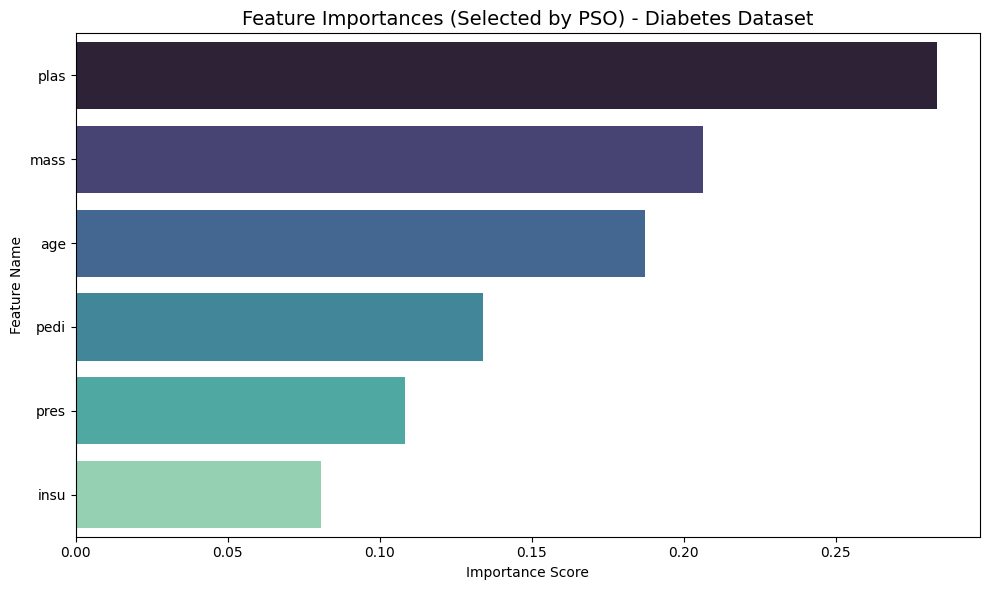

C:\Users\PARIYA\AppData\Local\Temp\ipykernel_23076\2180812459.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df_cancer, palette='mako')


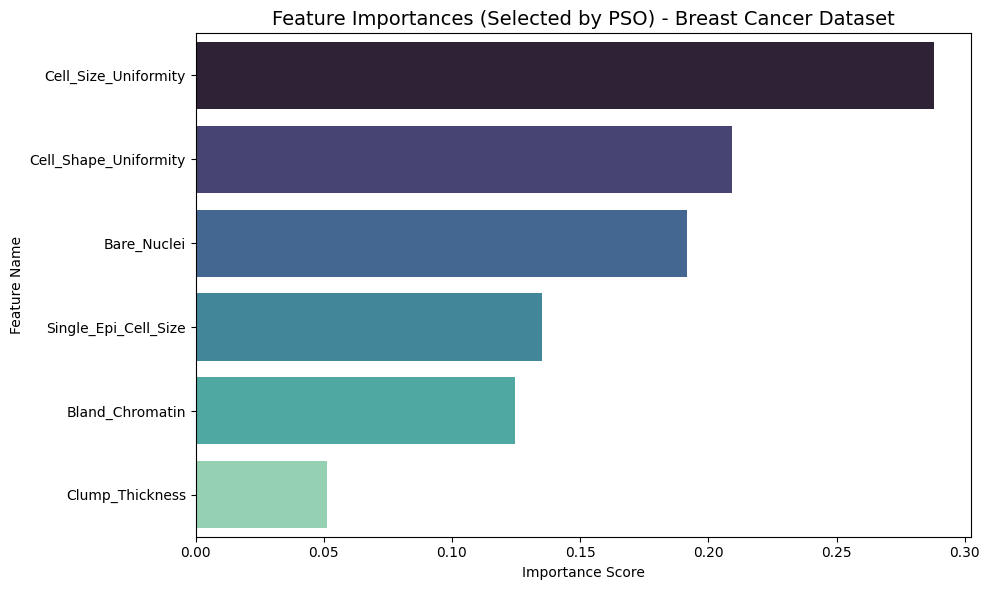

In [23]:
rf_diabetes = RandomForestClassifier(n_estimators=100, random_state=42)
rf_diabetes.fit(X_np[:, selected_features_mask], y_np)

importances_diabetes = rf_diabetes.feature_importances_
selected_names_diabetes = X_diabetes.columns[selected_features_mask]

importance_df_diabetes = pd.DataFrame({
    'Feature': selected_names_diabetes,
    'Importance': importances_diabetes
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_diabetes, palette='mako')
plt.title('Feature Importances (Selected by PSO) - Diabetes Dataset', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


rf_cancer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cancer.fit(X_np_cancer[:, selected_features_mask_cancer], y_np_cancer)

importances_cancer = rf_cancer.feature_importances_
selected_names_cancer = X_cancer.columns[selected_features_mask_cancer]

importance_df_cancer = pd.DataFrame({
    'Feature': selected_names_cancer,
    'Importance': importances_cancer
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_cancer, palette='mako')
plt.title('Feature Importances (Selected by PSO) - Breast Cancer Dataset', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()


In [14]:
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

In [15]:
X_selected = X_diabetes_balanced.iloc[:, selected_features_mask]


model_scores = {name: [] for name in models.keys()}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for train_index, test_index in kf.split(X_selected, y_diabetes_balanced):
    X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train, y_test = y_diabetes_balanced[train_index], y_diabetes_balanced[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        model_scores[name].append(acc)

print("🎯 Average Accuracy per Model:")
for name, scores in model_scores.items():
    print(f"{name}: {np.mean(scores):.4f}")


🎯 Average Accuracy per Model:
Random Forest: 0.8180
KNN: 0.7400
SVM: 0.7230
Decision Tree: 0.7730
Naive Bayes: 0.7480


In [18]:
X_selected_cancer = X_cancer_balanced.iloc[:, selected_features_mask_cancer]

kf_cancer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model_scores_cancer = {name: [] for name in models.keys()}

for train_index, test_index in kf_cancer.split(X_selected_cancer, y_cancer_balanced):
    X_train_cancer, X_test_cancer = X_selected_cancer.iloc[train_index], X_selected_cancer.iloc[test_index]
    y_train_cancer, y_test_cancer = y_cancer_balanced[train_index], y_cancer_balanced[test_index]

    for name, model in models.items():
        model.fit(X_train_cancer, y_train_cancer)
        y_pred_cancer = model.predict(X_test_cancer)
        acc_cancer = accuracy_score(y_test_cancer, y_pred_cancer)
        model_scores_cancer[name].append(acc_cancer)

print("\n🎯 Average Accuracy per Model (Cancer Dataset):")
for name, scores in model_scores_cancer.items():
    print(f"{name}: {np.mean(scores):.4f}")



🎯 Average Accuracy per Model (Cancer Dataset):
Random Forest: 0.9760
KNN: 0.9814
SVM: 0.9749
Decision Tree: 0.9476
Naive Bayes: 0.9694
